## Machine Translation

In [1]:
import tensorflow as tf
from utils import util_functions as utils

2024-12-27 13:04:03.845884: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-12-27 13:04:03.845909: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-12-27 13:04:03.845915: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-12-27 13:04:03.845968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-27 13:04:03.846209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
class MTFraEng(utils.DataModule):
  def _download(self):
    """Download File"""
    with open("../data/fra-eng/fra.txt", encoding='utf-8') as f:
      return f.read()
  
  def _preprocess(self, raw_text):
    """Remove non breaking spaces, add space before special character"""
    text = raw_text.replace('\u202f', ' ').replace('\xa0' , ' ')
    text.lower()
    no_space = lambda char, prev_char: char in ',?.!' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char 
           for i, char in enumerate(text.lower())]
    return ''.join(out)    
  
  def _get_src_tgt_arrays(self):
    raw_text = self._download()
    text = self._preprocess(raw_text)
    examples = text.split('\n')
    self.num_samples = len(examples)
    eng, fra = [], []
    for example in examples:
      example = example.split('\t')
      if (len(example) == 2):
        eng.append(example[0])
        fra.append(example[1])

    return eng, fra

  def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super().__init__()
    self.save_hyperparameters()
    
  def build(self, src_examples, tgt_examples, train=True):
    src_tokens = []
    for src_example in src_examples:
      # Add <eos> at end of each example
      # Pad sentences to length of num_steps using <pad> token
      # Convert each example into list of tokens
      src_example = src_example.split(' ') + ['<eos>']
      l = len(src_example)
      src_example = src_example[:self.num_steps] if l > self.num_steps else src_example + ['<pad>'] * (self.num_steps - l)
      src_tokens.append(src_example)

    tgt_tokens = []
    for tgt_example in tgt_examples:
      # Add <eos> at end of each example
      # Add <bos> at end of each example
      # Pad sentences to length of num_steps using <pad> token
      # Convert each example into list of tokens
      tgt_example =  ['<bos>'] + tgt_example.split(' ') + ['<eos>']
      l = len(tgt_example)
      tgt_example = tgt_example[:self.num_steps] if l > self.num_steps else tgt_example + ['<pad>'] * (self.num_steps - l)
      tgt_tokens.append(tgt_example)

    if train:
      self.src_vocab = utils.Vocab(tokens=src_tokens, min_freq=2)
      self.tgt_vocab = utils.Vocab(tokens=tgt_tokens, min_freq=2)
    
    self.src_array = tf.constant([self.src_vocab[s] for s in src_tokens])
    self.src_valid_len = tf.reduce_sum(input_tensor=tf.cast(
      x=self.src_array != self.src_vocab['<pad>'], dtype=tf.int32), 
      axis=1
    )
    self.tgt_array = tf.constant([self.tgt_vocab[s] for s in tgt_tokens])
    self.arrays = (self.src_array, self.tgt_array[:, :-1], self.src_valid_len, self.tgt_array[:, 1:])
    return self.arrays
  
  def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(tensors=self.arrays, train=train, indices=i)

In [3]:
data = MTFraEng(batch_size=2)
src_examples, target_examples = data._get_src_tgt_arrays()
data.build(src_examples, target_examples)

(<tf.Tensor: shape=(167130, 9), dtype=int32, numpy=
 array([[3799,   77,  189, ...,  190,  190,  190],
        [4159,   77,  189, ...,  190,  190,  190],
        [7290,    0,  189, ...,  190,  190,  190],
        ...,
        [7725, 8641,  613, ..., 5887,  538, 3780],
        [4379, 7928, 9498, ...,  803, 7378, 8625],
        [4685, 5305,  903, ...,  194, 1846,  191]], dtype=int32)>,
 <tf.Tensor: shape=(167130, 8), dtype=int32, numpy=
 array([[  133, 15861,     1, ...,   135,   135,   135],
        [  133, 13915,     1, ...,   135,   135,   135],
        [  133,  3246,     1, ...,   135,   135,   135],
        ...,
        [  133, 12133, 16376, ...,  9779, 14272, 16367],
        [  133, 14211, 12328, ...,  2892, 10889, 16251],
        [  133,  7031,  5612, ...,  3828, 15807,   136]], dtype=int32)>,
 <tf.Tensor: shape=(167130,), dtype=int32, numpy=array([3, 3, 3, ..., 9, 9, 9], dtype=int32)>,
 <tf.Tensor: shape=(167130, 8), dtype=int32, numpy=
 array([[15861,     1,   134, ...,   135,  

In [4]:
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))

In [5]:
print('source ', tf.cast(src, tf.int32))

source  tf.Tensor(
[[4830 5310   77  189  190  190  190  190  190]
 [7369 8780   77  189  190  190  190  190  190]], shape=(2, 9), dtype=int32)


In [6]:
print('target ', tf.cast(tgt, tf.int32))

target  tf.Tensor(
[[  133  5225    28   134   135   135   135   135]
 [  133   136 15372    28   134   135   135   135]], shape=(2, 8), dtype=int32)


In [7]:
print('valid len ', tf.cast(src_valid_len, tf.int32))

valid len  tf.Tensor([4 4], shape=(2,), dtype=int32)


In [8]:
print('label ', tf.cast(label, tf.int32))

label  tf.Tensor(
[[ 5225    28   134   135   135   135   135   135]
 [  136 15372    28   134   135   135   135   135]], shape=(2, 8), dtype=int32)


## Encoder Implementation

In [9]:
class Encoder(tf.keras.layers.Layer):
  """Base Encoder Interface for encoder--decoder architecture"""
  def __init__(self):
    super().__init__()

  def call(self, X, *args):
    """
    X: shape (num_steps, batch_size)
    Output: (num_steps, batch_size, num_hidden), state
    """
    raise NotImplementedError

In [17]:
class Seq2SeqEncoder(Encoder):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers=2, dropout=0):
    super().__init__()
    
    ## accepts (batch_size, num_steps) as input
    ## gives out (batch_size, num_steps, embed_size)
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size)

    ## Accepts (batch_size, num_steps, embed_size)
    ## gives out (batch_size, num_steps, num_hiddens), [(batch_size, num_hiddens)]
    self.rnn = utils.DeepRNN(num_hiddens=num_hiddens, num_layers=2, dropout=dropout)

  def call(self, X, *args):
    ## Accepts (batch_size, num_steps)
    ## gives out (batch_size, num_steps, num_hiddens), [(batch_size, num_hiddens)]

    encoder_inputs = self.embedding(X)
    encoder_outputs, states = self.rnn(X=encoder_inputs, state=None)
    return encoder_outputs, states

In [18]:
X = tf.zeros(shape=(32, 9))
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=32, num_hiddens=16, num_layers=2)
outputs, state = encoder(X)
print(X.shape)
print("RNN Output: ",outputs.shape)
print(state[0].shape)

(32, 9)
RNN Output:  (32, 9, 16)
(32, 16)


In [19]:
tf.__version__

'2.15.0'

In [20]:
import numpy as np
inputs = np.random.random((32, 10, 8))
rnn = tf.keras.layers.RNN(
   tf.keras.layers.GRUCell(4),
   return_sequences=True,
   return_state=True)
whole_sequence_output, final_state = rnn(inputs)
whole_sequence_output.shape

TensorShape([32, 10, 4])

In [21]:
final_state.shape

TensorShape([32, 4])

In [22]:
class Decoder(tf.keras.layers.Layer):
  """Base Decoder Interface for encoder--decoder architecture"""
  def __init__(self):
    super().__init__()

  def init_state(self, enc_all_outputs, *args):
    """returns encoder outs"""
    raise NotImplementedError
  
  def call(self, X, state):
    """
    X: shape (batch_size, num_steps)
    state: from encoder encoder outputs
    Output: (num_steps, batch_size, vocab_size)
    """
    raise NotImplementedError

In [23]:
class Seq2SeqDecoder(tf.keras.layers.Layer):
  """Base Decoder Interface for encoder--decoder architecture"""
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers=2, dropout=0):
    super().__init__()
    
    ## accepts (batch_size, num_steps) as input
    ## gives out (batch_size, num_steps, embed_size)
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size)

    ## Accepts (batch_size, num_steps, embed_size)
    ## gives out (batch_size, num_steps, num_hiddens), [(batch_size, num_hiddens)]
    self.rnn = utils.DeepRNN(num_hiddens=num_hiddens, num_layers=2, dropout=dropout)
    self.dense = tf.keras.layers.Dense(units=vocab_size)
    
  def init_state(self, enc_all_outputs, *args):
    """returns encoder outs"""
    return enc_all_outputs
  
  def call(self, X, state):
    """
    X: shape (batch_size, num_steps)
    state: from encoder encoder outputs
    Output: (batch_size, num_steps, vocab_size)
    """
    num_steps = X.shape[1]
    batch_size = X.shape[0]
    decoder_inputs = self.embedding(X)
    encoder_outputs, hidden_state = state
    
    context_vector = tf.reshape(tensor=encoder_outputs[:, -1, :], shape=(batch_size, -1)) #(batch_size, num_hiddens)

    context_vector = tf.expand_dims(input=context_vector, axis=1) # (batch_size, 1, num_hiddens)
    context_vector = tf.tile(input=context_vector, multiples=[1, num_steps, 1]) # (batch_size, num_steps, num_hiddens)

    decoder_inputs = tf.concat([decoder_inputs, context_vector], axis=-1)

    decoder_outputs, hidden_state = self.rnn(X=decoder_inputs, state=hidden_state)  # (batch_size, num_steps, num_hiddens)
    outputs = self.dense(decoder_outputs) # (batch_size, num_steps, vocab_size)
    return outputs, [encoder_outputs, hidden_state]

In [24]:
class EncoderDecoder(utils.Classifier):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def call(self, enc_X, dec_X, *args):
    """
      enc_X: Encoder Inputs (batch_size, num_steps)
      dec_X: Decoder Inputs (batch_size, num_steps-1)
    """
    enc_all_outputs = self.encoder(enc_X, *args, training=True)
    dec_state = self.decoder.init_state(enc_all_outputs, *args)
    return self.decoder(dec_X, dec_state, training=True)[0]

In [30]:
class Seq2SeqEncoderDecoder(EncoderDecoder):
  def __init__(self, encoder, decoder, tgt_pad, lr):
    super().__init__(encoder, decoder)
    self.save_hyperparameters()
    
  def call(self, enc_X, dec_X, *args):
    enc_all_outputs = self.encoder(enc_X, *args, training=True)
    dec_state = self.decoder.init_state(enc_all_outputs, *args)
    return self.decoder(dec_X, dec_state, training=True)[0]
  
  def loss(self, y_hat, y):
    loss = super().loss(y=y, y_hat=y_hat, averaged=False)
    mask = tf.cast(tf.reshape(y, shape=loss.shape) != self.tgt_pad, dtype=tf.float32)
    loss = tf.reduce_sum(mask * loss) / tf.reduce_sum(mask)
    return loss
  
  def validation_step(self, batch):
    Y_hat = self(*batch[:-1])
    self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

  def configure_optimizers(self):
    return tf.keras.optimizers.legacy.Adam(self.lr)
  
  def predict(self, batch, tgt_vocab, num_steps, save_attention_weights=False):
    arrays = data.build(src_examples=batch[0], tgt_examples=batch[1], train=False)
    src, tgt, valid_len, label = arrays
    enc_all_outputs = self.encoder(X=src)
    dec_state = self.decoder.init_state(enc_all_outputs, valid_len)
    outputs = [tf.expand_dims(tgt[:, 0], 1)]
    attention_weights = []
    for _ in range(num_steps):
      dec_output, dec_state = self.decoder(outputs[-1], dec_state, training=False)
      outputs.append(tf.argmax(dec_output, axis=2))
      if save_attention_weights:
        attention_weights.append(self.decoder.attention_weights)
        
    return tf.concat(outputs[1:], axis=1), attention_weights

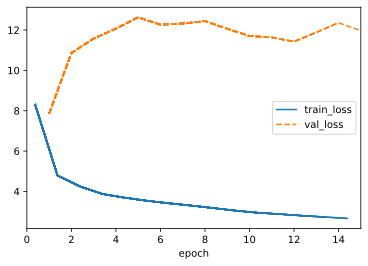

In [31]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
with tf.device('CPU: 0'):
  data = MTFraEng(batch_size=128)
  src, tgt = data._get_src_tgt_arrays()
  data.build(src_examples=src, tgt_examples=tgt)
  encoder = Seq2SeqEncoder(vocab_size=len(data.src_vocab), embed_size=embed_size, num_hiddens=num_hiddens, num_layers=num_layers, dropout=dropout)
  decoder = Seq2SeqDecoder(vocab_size=len(data.tgt_vocab), embed_size=embed_size, num_hiddens=num_hiddens, num_layers=num_layers, dropout=dropout)
  model = Seq2SeqEncoderDecoder(encoder=encoder, decoder=decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.01)

  trainer = utils.Trainer(max_epochs=15, gradient_clip_val=1)
  trainer.fit(model, data)

In [32]:
engs = src[:5]
fras = tgt[:5]
# batch = data.build(src_examples=src, tgt_examples=tgt)

model_outputs = model.predict(batch=(engs, fras), tgt_vocab=data.tgt_vocab, num_steps=9, save_attention_weights=False)

In [33]:
model_outputs

(<tf.Tensor: shape=(5, 9), dtype=int64, numpy=
 array([[7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670],
        [7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670],
        [ 136,  136,  136,  136,  136,  136,  136,  136,  136],
        [ 136,  136,  136,  136,  136,  136,  136,  136,  136],
        [7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670, 7670]])>,
 [])

In [34]:
data.tgt_vocab.idx_to_token[136]

'<unk>'

In [ ]:
src